In [1]:
# based on https://github.com/e-hulten/planar-flows

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torch import Tensor
from typing import Tuple, Callable

from torch.utils.data import DataLoader

if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 3
    torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE='cpu'
# DEVICE='cpu'

import sys
sys.path.append('../../homeworks') # to grab dgm_utils from ../../homeworks directory
from dgm_utils import visualize_2d_data, visualize_2d_densities
from dgm_utils import train_model, plot_training_curves, show_samples
from seminar5_utils import make_numpy, DataLoaderWrapper

import matplotlib.pyplot as plt
import numpy as np

## Planar Flow


$g(\mathbf{z}) = \mathbf{z} + \mathbf{u}h(\mathbf{w}^T\mathbf{z} + b)$


$\theta = \{\mathbf{u,w} \in \mathbb{R}^d, b \in \mathbb{R}\}$

$\dfrac{\partial g(\mathbf{z}, \theta)}{\partial \mathbf{z}} =  \mathbf{I} + \mathbf{u}h'(\mathbf{w}^T\mathbf{z} + b)\mathbf{w}^T$

$\det \left(\dfrac{\partial g(\mathbf{z}, \theta)}{\partial \mathbf{z}}\Big{|}_{\mathbf{z} = \mathbf{z}}\right) = \left(1 + h'(\mathbf{w}^T\mathbf{z} + b)\mathbf{w}^T\mathbf{I}^{-1}\mathbf{u} \right) \det(\mathbf{I}) =1 + h'(\mathbf{w}^T\mathbf{z} + b)\mathbf{w}^T \mathbf{u}$

$\begin{cases} h = \tanh\\ \mathbf{w}^T \mathbf{u} > -1 \end{cases} \Rightarrow g \text{ is invertible}$

In [3]:
class PlanarTransform(nn.Module):
    """Implementation of the invertible transformation used in planar flow:
        g(z) = z + u * h(dot(w.T, z) + b)
    See Section 4.1 in https://arxiv.org/pdf/1505.05770.pdf. 
    """

    def __init__(self, dim: int = 2):
        """Initialise weights and bias.
        
        Args:
            dim: Dimensionality of the distribution to be estimated.
        """
        super().__init__()
        self.w = nn.Parameter(torch.randn(1, dim).normal_(0, 0.1))
        self.b = nn.Parameter(torch.randn(1).normal_(0, 0.1))
        self.u = nn.Parameter(torch.randn(1, dim).normal_(0, 0.1))

    def forward(self, z: Tensor):
        if torch.mm(self.u, self.w.T) < -1:
            self.get_u_hat()

        return z + self.u * nn.Tanh()(torch.mm(z, self.w.T) + self.b)

    def log_det_J(self, z: Tensor):
        if torch.mm(self.u, self.w.T) < -1:
            self.get_u_hat()
        a = torch.mm(z, self.w.T) + self.b
        psi = (1 - nn.Tanh()(a) ** 2) * self.w
        abs_det = (1 + torch.mm(self.u, psi.T)).abs()
        log_det = torch.log(1e-4 + abs_det)

        return log_det

    def get_u_hat(self):
        """Enforce w^T u >= -1. When using h(.) = tanh(.), this is a sufficient condition 
        for invertibility of the transformation f(z). See Appendix A.1. 
        of https://arxiv.org/pdf/1505.05770.pdf
        """
        wtu = torch.mm(self.u, self.w.T)
        m_wtu = -1 + torch.log(1 + torch.exp(wtu))
        self.u.data = (
            self.u + (m_wtu - wtu) * self.w / torch.norm(self.w, p=2, dim=1) ** 2
        )

**Enforcing $\mathbf{w}^T \mathbf{u} > -1$**

Consider $m(x) = log(1 + e^{x}) - 1$. Then $m(x) > -1$

Define $\hat{\mathbf{u}}(\mathbf{w}, \mathbf{u}) = \mathbf{u} + \left[m(\mathbf{w}^T \mathbf{u}) - (\mathbf{w}^T \mathbf{u})\right] \frac{\mathbf{w}}{\Vert \mathbf{w} \Vert_2^2}$. Then $\mathbf{w}^T \hat{\mathbf{u}} > -1$

In [4]:
class PlanarFlow(nn.Module):
    def __init__(self, dim: int = 2, K: int = 6):
        """Make a planar flow by stacking planar transformations in sequence.
        Args:
            dim: Dimensionality of the distribution to be estimated.
            K: Number of transformations in the flow. 
        """
        super().__init__()
        self.layers = [PlanarTransform(dim) for _ in range(K)]
        self.model = nn.Sequential(*self.layers)

    def forward(self, z: Tensor):
        log_det_J = 0
        for layer in self.layers:
            z = layer(z)
            log_det_J+=layer.log_det_J(z)
        
        return z, log_det_J
    
    def seq_forward(self, z: Tensor):
        res = []
        with torch.no_grad():
            for layer in self.layers:
                z = layer(z)
                res.append(z)

        
        return res

## Forward KL

In [5]:
from sklearn.datasets import make_moons

def generate_moons_data(count):
    data, labels = make_moons(n_samples=count, noise=0.1)
    data = data.astype('float32')
    split = int(0.8 * count)
    train_data, test_data = data[:split], data[split:]
    train_labels, test_labels = labels[:split], labels[split:]
    return train_data, train_labels, test_data, test_labels
    
    
def visualize_seq(seq_data, labels=None, figsize=None, b=5):
    a = len(seq_data) // b + 1*((len(seq_data) % b)>0)
    if figsize is None:
        figsize = (5*b, 5*a)
    
    fig, axs = plt.subplots(a, b, figsize=figsize)
    if len(seq_data)<=b:
        for k,data in enumerate(seq_data):
            data = make_numpy(data)
            axs[k].set_title(k, fontsize=16)
            axs[k].scatter(data[:, 0], data[:, 1], s=1, c=labels)
            axs[k].tick_params(labelsize=16)


    else:
        for k,data in enumerate(seq_data):
            data = make_numpy(data)
            i = k//b
            j = k%b
            axs[i][j].set_title(k, fontsize=16)
            axs[i][j].scatter(data[:, 0], data[:, 1], s=1, c=labels)
            axs[i][j].tick_params(labelsize=16)

    plt.show()

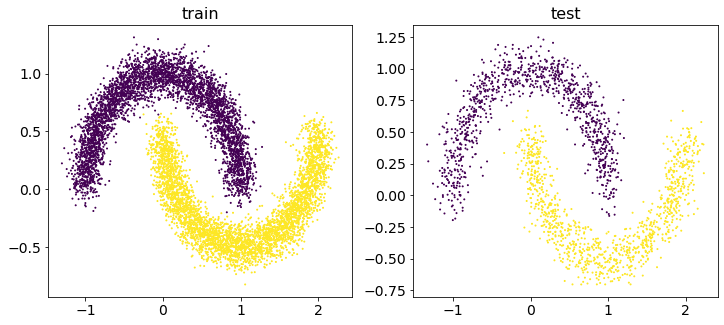

In [6]:
COUNT = 10000

train_data, train_labels, test_data, test_labels = generate_moons_data(COUNT)
visualize_2d_data(train_data, test_data, train_labels, test_labels)

In [7]:
####

<img src="pics/forwardkl.png" width=600 height=800 />

<img src="pics/forward_for_flow.png" width=600 height=800 />

In [8]:
from torch.distributions import MultivariateNormal
from torch import Tensor

class ForwardKL(nn.Module):

    @property
    def base_distr(self):
        return MultivariateNormal(self.mu, self.sigma)

    def __init__(self):
        super().__init__()
        self.register_buffer('mu', torch.zeros(2))
        self.register_buffer('sigma', torch.eye(2))

    def forward(self, z: Tensor, sum_log_det_J: float):
        log_p_z = self.base_distr.log_prob(z)
        return -1*(log_p_z + sum_log_det_J).mean()

class PlanarFlowForwardKL(PlanarFlow):
    
    def __init__(self, dim: int = 2, K: int = 6):
        super().__init__(dim, K)
        self.forward_kl = ForwardKL()
    
    def loss(self, x):
        zk, log_det_J = self.forward(x)
        loss = self.forward_kl(zk, log_det_J)
        return {'forward_kl': loss}

In [12]:
flow_length = 64
dim = 2

# model = PlanarFlow(dim, K=flow_length).to(DEVICE)
# loss_f = ForwardKL().to(DEVICE)
model = PlanarFlowForwardKL(dim, K=flow_length).to(DEVICE)

In [13]:
EPOCHS = 60
BATCH_SIZE = 256
LR = 1e-2
USE_CUDA=True

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

train_losses, test_losses = train_model(
    model, 
    train_loader, 
    test_loader, 
    epochs=EPOCHS, 
    lr=LR, 
    use_tqdm=True, 
    use_cuda=USE_CUDA,
    loss_key='forward_kl'
)

  0%|          | 0/60 [00:00<?, ?it/s]

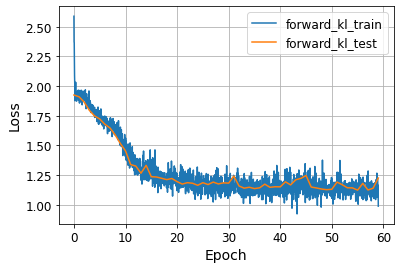

In [14]:
plot_training_curves(train_losses, test_losses)

Visualizing $f_{\theta}(X)$, $X \sim \pi(x)$

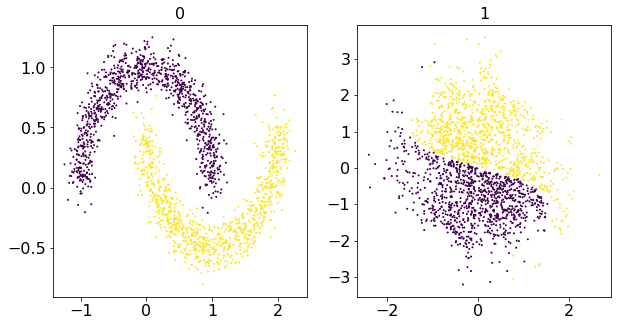

In [15]:
test_res, log_det_J = model(torch.from_numpy(test_data).to(DEVICE))
test_res = test_res.detach().cpu().numpy()
visualize_seq([test_data, test_res], test_labels, figsize=(10,5), b=2)

In [16]:
def visualize_flow_densities(model):
    
    dx, dy = 0.025, 0.025
    x_lim = (-1.5, 2.5)
    y_lim = (-1, 1.5)
    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                    slice(x_lim[0], x_lim[1] + dx, dx)]
    mesh_xs = torch.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2)).to(DEVICE)
    
    with torch.no_grad():
        z, sum_log_det_J = model(mesh_xs)
    
    log_p_z = model.forward_kl.base_distr.log_prob(z)
    densities = torch.exp(log_p_z + sum_log_det_J).detach().cpu().numpy()
    
    visualize_2d_densities(x, y, densities, r'$\pi(x)$ density', xlabel=None, ylabel=None)

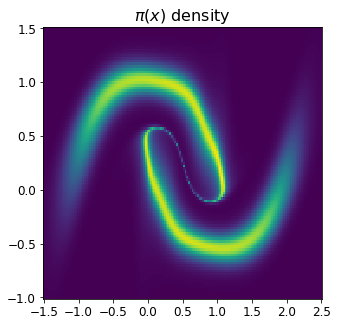

In [17]:
visualize_flow_densities(model)

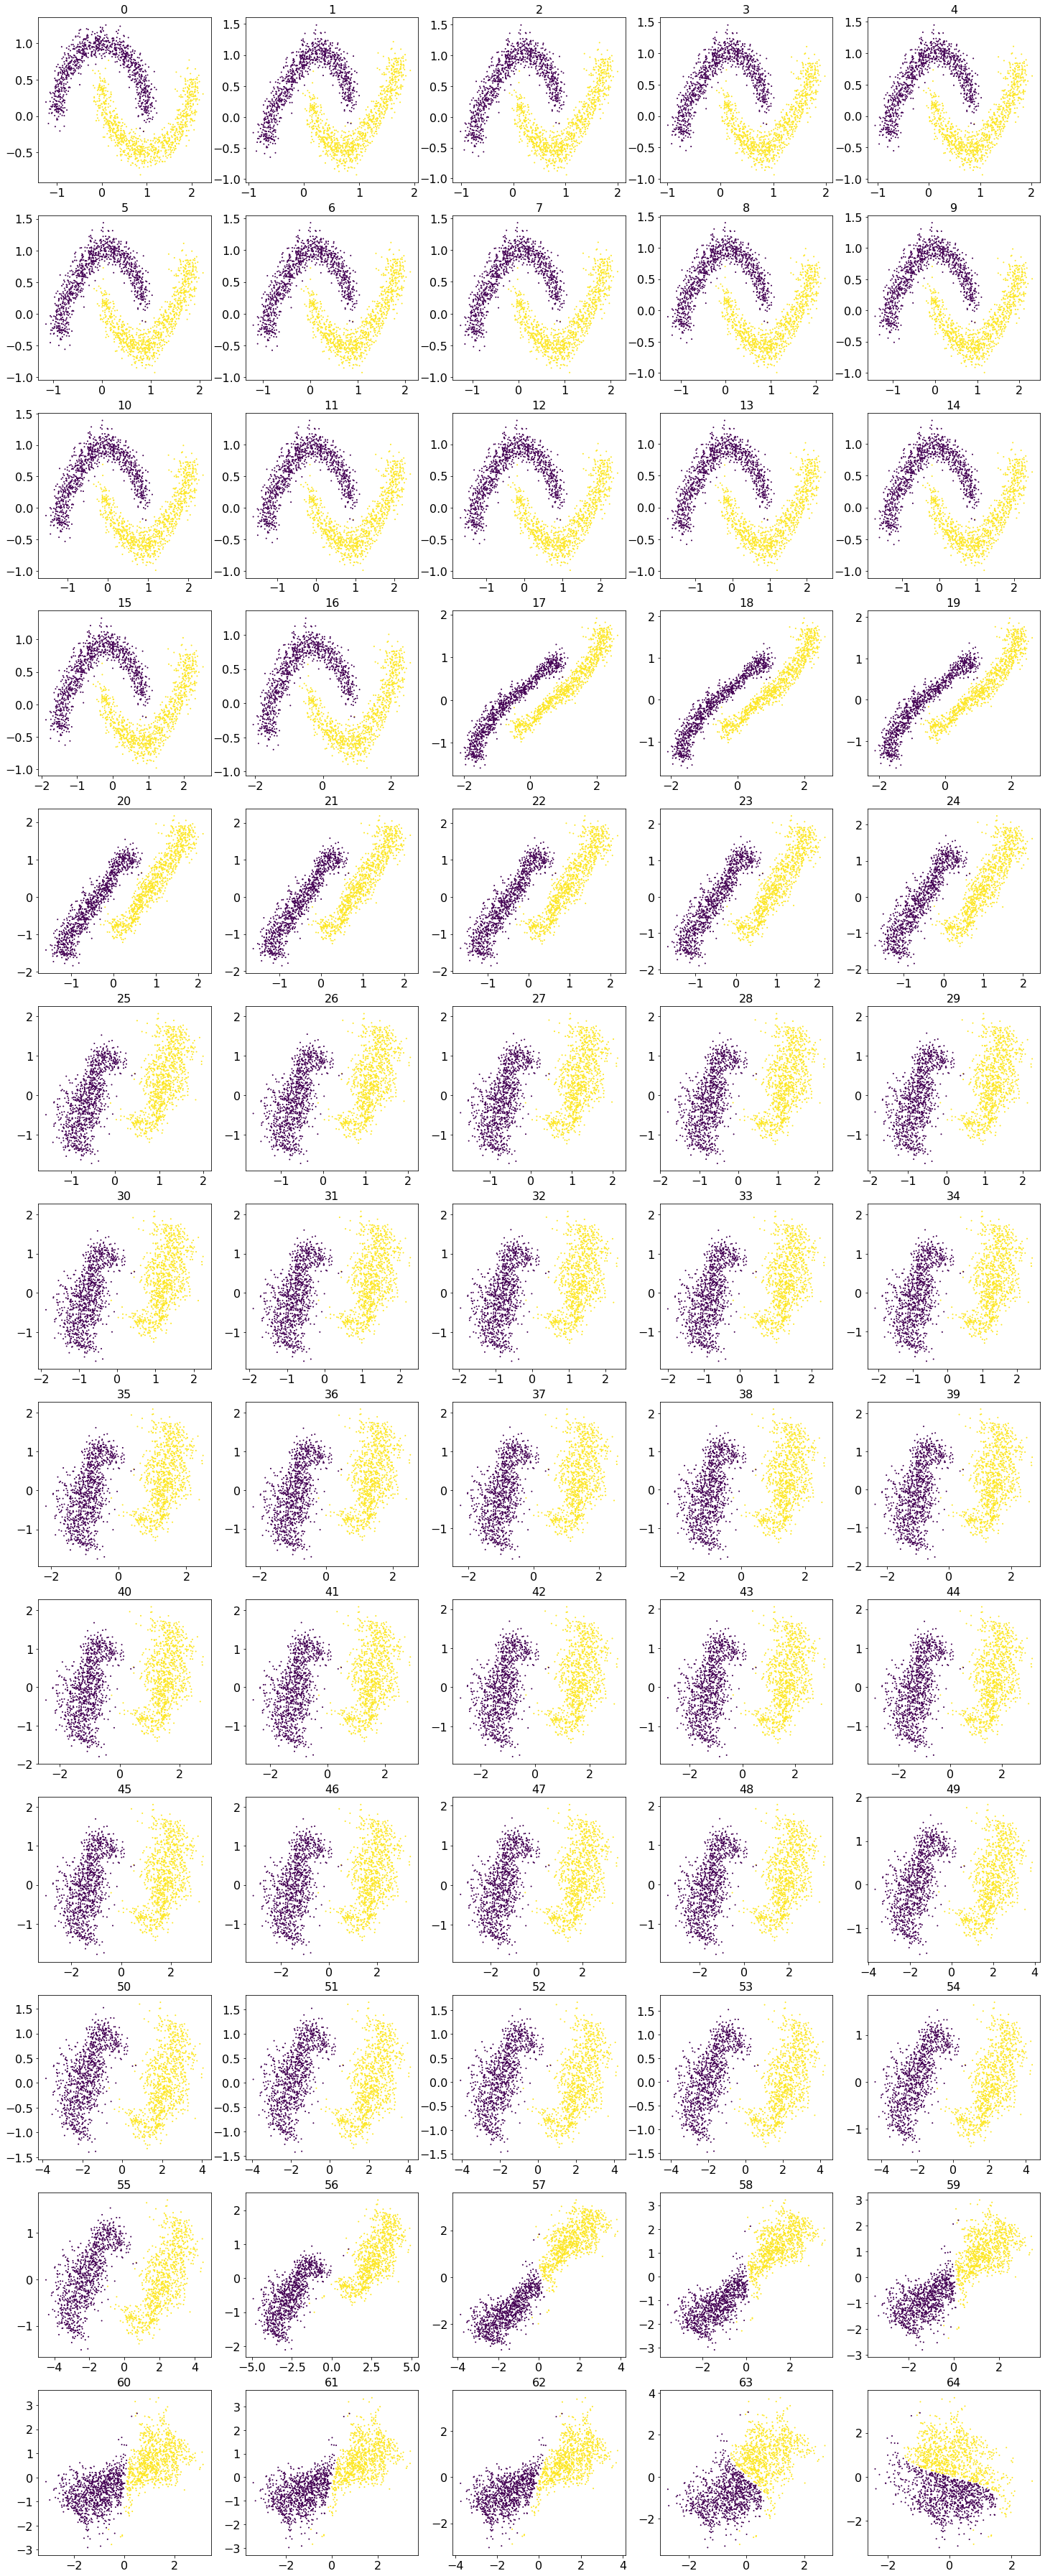

In [18]:
visualize_seq([test_data]+model.seq_forward(torch.from_numpy(test_data).to(DEVICE)), test_labels)

## Reverse KL

In [9]:
class TargetDistribution:
    def __init__(self, name: str):
        """Define target distribution. 
        Args:
            name: The name of the target density to use. 
                  Valid choices: ["U_1", "U_2", "U_3", "U_4", "ring"].
                  
        !!! We are working with - log, so to get density we should use P = torch.exp(-density(Z))
        """
        self.func = self.get_target_distribution(name)

    def __call__(self, z: Tensor) -> Tensor:
        return self.func(z)

    @staticmethod
    def get_target_distribution(name: str) -> Callable[[Tensor], Tensor]:
        w1 = lambda z: torch.sin(2 * np.pi * z[:, 0] / 4)
        w2 = lambda z: 3 * torch.exp(-0.5 * ((z[:, 0] - 1) / 0.6) ** 2)
        w3 = lambda z: 3 * torch.sigmoid((z[:, 0] - 1) / 0.3)

        if name == "U_1":

            def U_1(z):
                u = 0.5 * ((torch.norm(z, 2, dim=1) - 2) / 0.4) ** 2
                u = u - torch.log(
                    torch.exp(-0.5 * ((z[:, 0] - 2) / 0.6) ** 2)
                    + torch.exp(-0.5 * ((z[:, 0] + 2) / 0.6) ** 2)
                )
                return u

            return U_1
        elif name == "U_2":

            def U_2(z):
                u = 0.5 * ((z[:, 1] - w1(z)) / 0.4) ** 2
                return u

            return U_2
        elif name == "U_3":

            def U_3(z):
                u = -torch.log(
                    torch.exp(-0.5 * ((z[:, 1] - w1(z)) / 0.35) ** 2)
                    + torch.exp(-0.5 * ((z[:, 1] - w1(z) + w2(z)) / 0.35) ** 2)
                    + 1e-6
                )
                return u

            return U_3
        elif name == "U_4":

            def U_4(z):
                u = -torch.log(
                    torch.exp(-0.5 * ((z[:, 1] - w1(z)) / 0.4) ** 2)
                    + torch.exp(-0.5 * ((z[:, 1] - w1(z) + w3(z)) / 0.35) ** 2)
                    + 1e-6
                )
                return u

            return U_4
        elif name == "ring":

            def ring_density(z):
                exp1 = torch.exp(-0.5 * ((z[:, 0] - 2) / 0.8) ** 2)
                exp2 = torch.exp(-0.5 * ((z[:, 0] + 2) / 0.8) ** 2)
                u = 0.5 * ((torch.norm(z, 2, dim=1) - 4) / 0.4) ** 2
                u = u - torch.log(exp1 + exp2 + 1e-6)
                return u

            return ring_density


def plot_density(density, xlim=4, ylim=4, ax=None, cmap="Blues"):
    x = y = np.linspace(-xlim, xlim, 300)
    X, Y = np.meshgrid(x, y)
    shape = X.shape
    X_flatten, Y_flatten = np.reshape(X, (-1, 1)), np.reshape(Y, (-1, 1))
    Z = torch.from_numpy(np.concatenate([X_flatten, Y_flatten], 1))
    U = torch.exp(-density(Z))
    U = U.reshape(shape)
    if ax is None:
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(111)

    ax.set_xlim(-xlim, xlim)
    ax.set_ylim(-xlim, xlim)
    ax.set_aspect(1)

    ax.pcolormesh(X, Y, U, cmap=cmap, rasterized=True)
    ax.tick_params(
        axis="both",
        left=False,
        top=False,
        right=False,
        bottom=False,
        labelleft=False,
        labeltop=False,
        labelright=False,
        labelbottom=False,
    )
    return ax


def plot_available_distributions():
    target_distributions = ["U_1", "U_2", "U_3", "U_4", "ring"]
    cmaps = ["Reds", "Purples", "Oranges", "Greens", "Blues"]
    fig, axes = plt.subplots(1, len(target_distributions), figsize=(20, 5))
    for i, distr in enumerate(target_distributions):
        axlim = 7 if distr == "ring" else 5
        density = TargetDistribution(distr)
        plot_density(density, xlim=axlim, ylim=axlim, ax=axes[i], cmap=cmaps[i])
        axes[i].set_title(f"Name: '{distr}'", size=16)
        plt.setp(axes, xticks=[], yticks=[])
    plt.show()

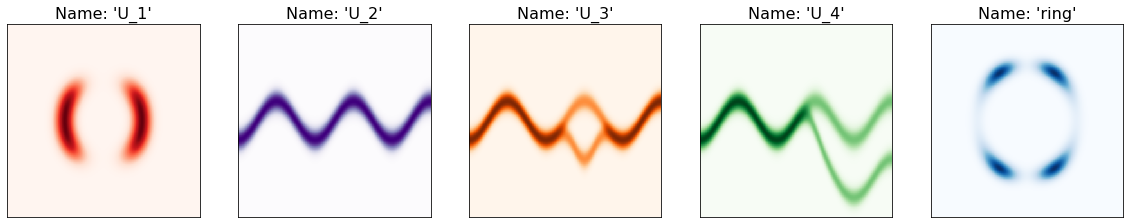

In [10]:
plot_available_distributions()

Let's fix `U_4` distribution

In [11]:
target_distr = 'U_4'

In [12]:
density = TargetDistribution(target_distr)

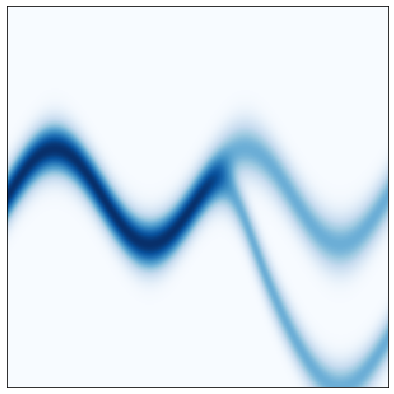

In [13]:
ax = plot_density(density)
plt.show()

<img src="pics/reversekl.png" width=600 height=800 />

<img src="pics/reverse_for_flow.png" width=600 height=800 />

In [26]:
class ReverseKL(nn.Module):

    @property
    def base_distr(self):
        return MultivariateNormal(self.mu, self.sigma)

    def __init__(self, distribution: TargetDistribution):
        super().__init__()
        self.register_buffer('mu', torch.zeros(2))
        self.register_buffer('sigma', torch.eye(2))
        self.distr = distribution

    def forward(self, z: Tensor, x: Tensor, sum_log_det_J: float):
        base_log_prob = self.base_distr.log_prob(z)
        target_density_log_prob = -self.distr(x)
        return (base_log_prob - sum_log_det_J - target_density_log_prob).mean()

class PlanarFlowReverseKL(PlanarFlow):
    
    def __init__(self, pi_distribution, dim: int = 2, K: int = 6):
        super().__init__(dim, K)
        self.reverse_kl = ReverseKL(pi_distribution)
    
    def loss(self, x):
        zk, log_det_J = self.forward(x)
        loss = self.reverse_kl(x, zk, log_det_J)
        return {'reverse_kl': loss}

In [27]:
#####

In [28]:
flow_length = 64
dim = 2

model = PlanarFlowReverseKL(density, dim, K=flow_length).to(DEVICE)

In [29]:
EPOCHS = 60
BATCH_SIZE = 256
BATCHES_PER_EPOCH = 50
LR = 5e-3
USE_CUDA=True

train_loader = DataLoaderWrapper(model.reverse_kl.base_distr, BATCH_SIZE, n_batches=BATCHES_PER_EPOCH)
test_loader = DataLoaderWrapper(model.reverse_kl.base_distr, BATCH_SIZE, n_batches=BATCHES_PER_EPOCH)


train_losses, test_losses = train_model(
    model, 
    train_loader, 
    test_loader, 
    epochs=EPOCHS, 
    lr=LR, 
    use_tqdm=True, 
    use_cuda=USE_CUDA,
    loss_key='reverse_kl'
)

  0%|          | 0/60 [00:00<?, ?it/s]

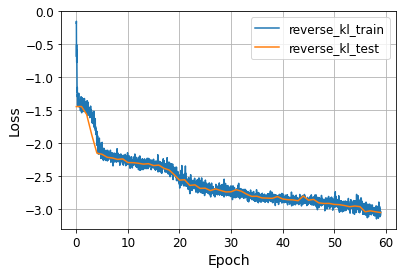

In [30]:
plot_training_curves(train_losses, test_losses)

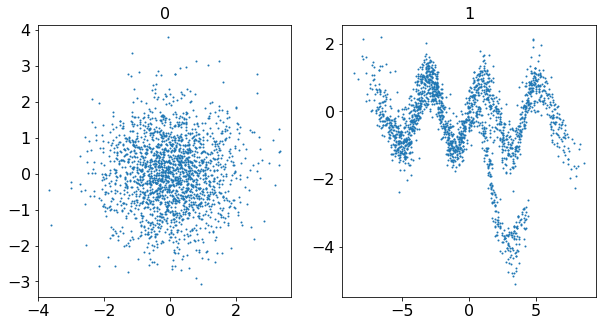

In [33]:
test_data = model.reverse_kl.base_distr.sample((2000,))
test_labels = None

with torch.no_grad():
    test_res, log_jacobian = model(test_data)

visualize_seq([test_data, test_res], test_labels, figsize=(10,5), b=2)

In [36]:
test_data = model.reverse_kl.base_distr.sample((1000,))
test_labels = np.linalg.norm(test_data.cpu().numpy(),axis=1) // 0.5

test_res = model.seq_forward(test_data)

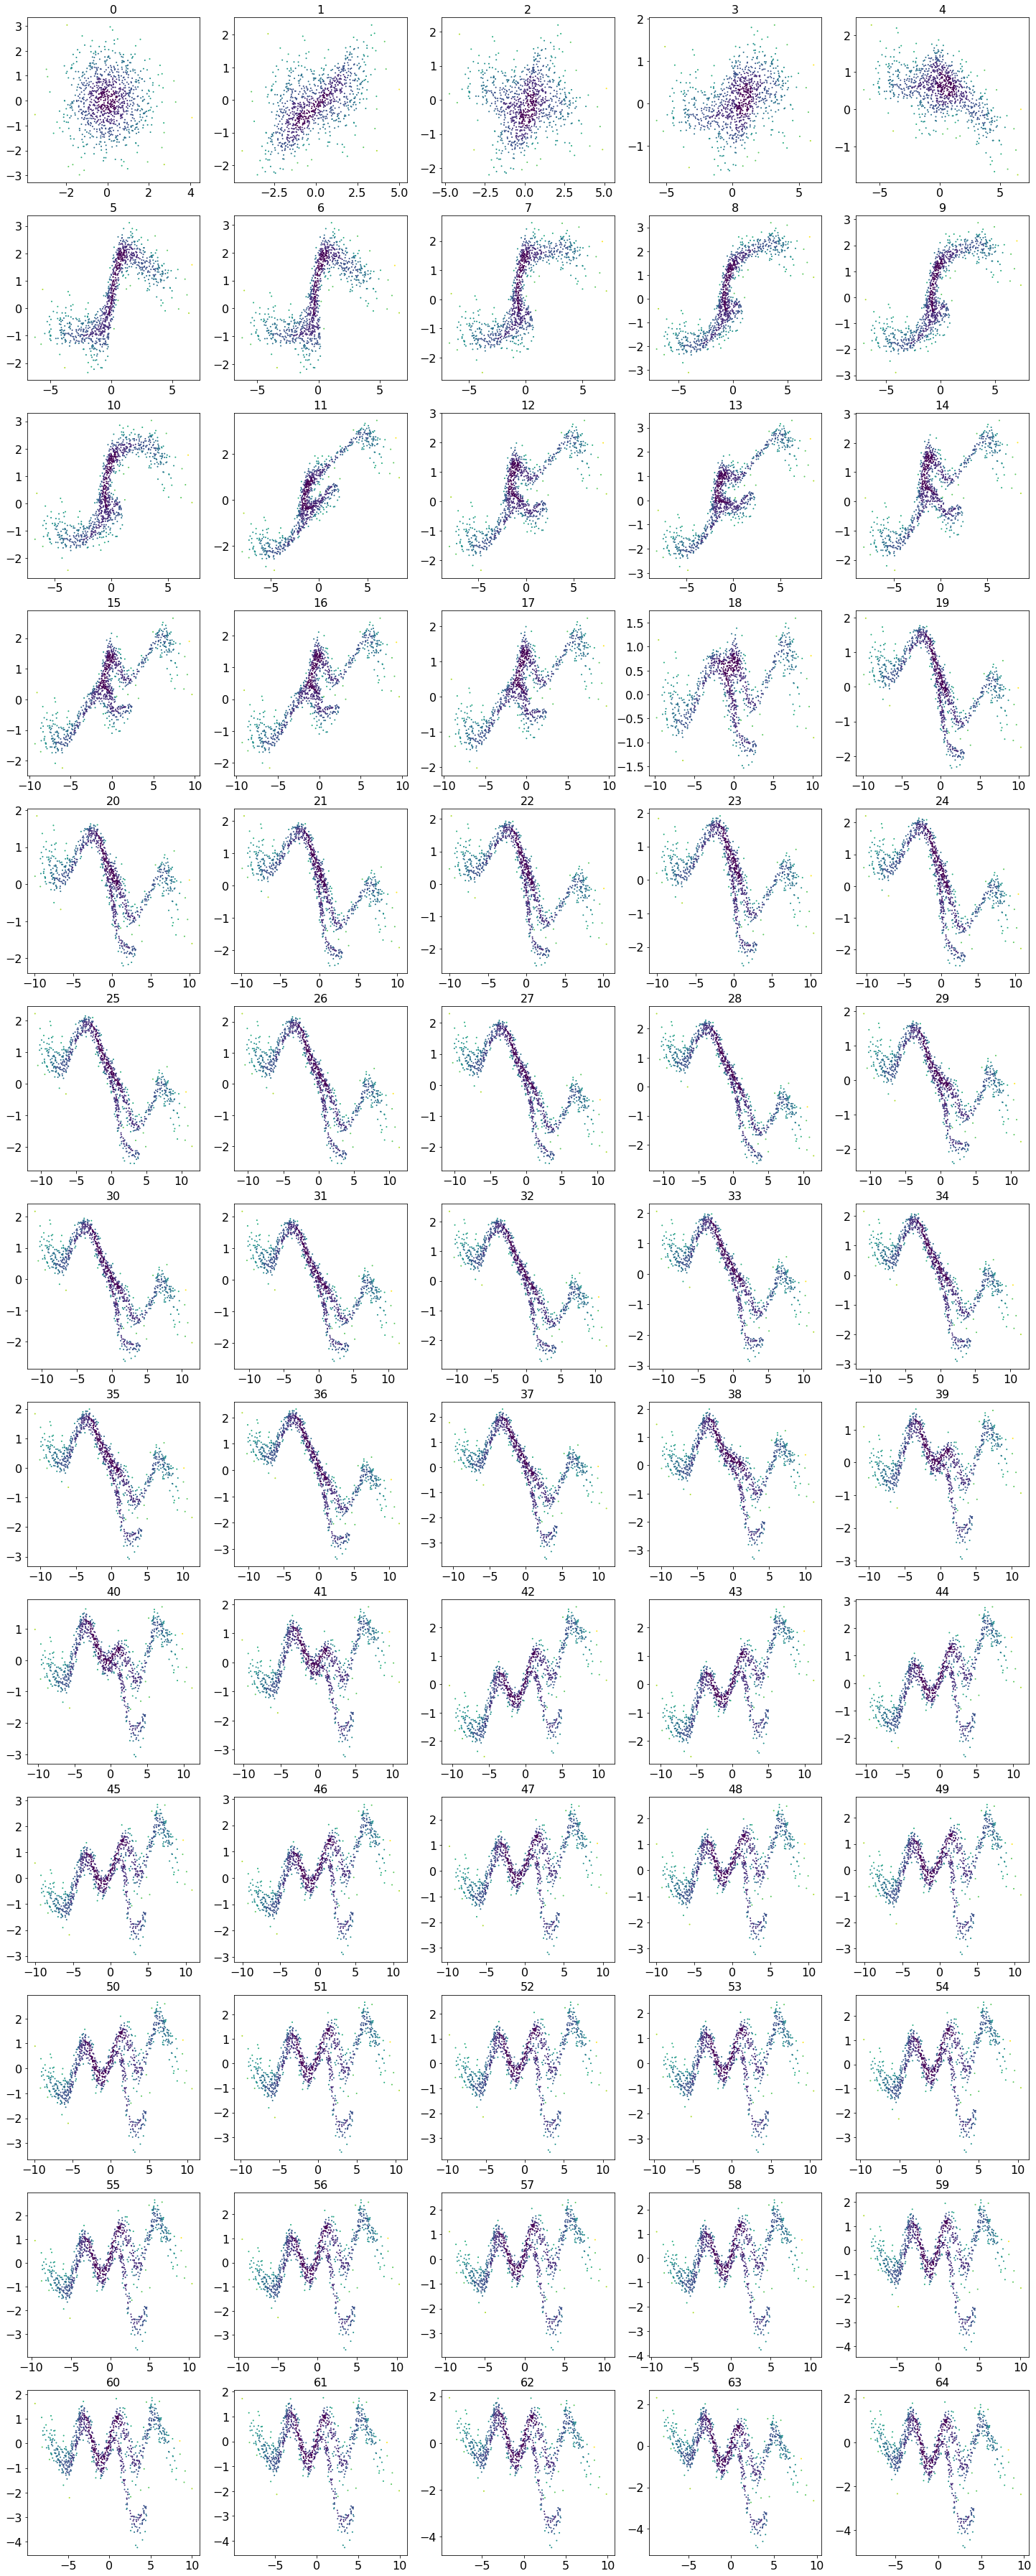

In [37]:
visualize_seq([test_data]+test_res, test_labels)